In [1]:
%matplotlib inline

import numpy as np
import scipy.fft as ft
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as tck
rng = np.random.default_rng()

In [2]:
# copied from 01_fourier 4988cf4f6e81b6b9510bf55a264011c37dc71872
def ft_spectrum( signal, sample_rate, fft=None, freq=None, mask_bias=False):
    """Return a FT of $signal$, with corresponding frequencies"""
    n_samples = len(signal)
    real_signal = np.isrealobj(signal)
    
    if fft is None:
        if real_signal:
            fft = ft.rfft
            freq = ft.rfftfreq
        else:
            fft = ft.fft
            freq = ft.fftfreq

    if freq is None:
        freq = ft.fftfreq
    
    spectrum = fft(signal) / sample_rate
    freqs = freq(n_samples, 1/sample_rate)
    
    if not mask_bias:
        return spectrum, freqs
    else:
        return spectrum[1:], freqs[1:]

    
def plot_spectrum( ax, spectrum, freqs, plot_complex=False, plot_power=False, plot_amplitude=None):
    """ Plot a signal's spectrum on an Axis object"""
    plot_amplitude = plot_amplitude or (not plot_power and not plot_complex)
    alpha = 1
    
    ax.set_title("Spectrum")
    ax.set_xlabel("f (Hz)")
    ylabel = ""
    if plot_amplitude or plot_complex:
        ylabel = "Amplitude"
    if plot_power:
        if ylabel:
            ylabel += "|"
        ylabel += "Power"
    ax.set_ylabel(ylabel)

    if plot_complex:
        alpha = 0.5
        ax.plot(freqs, np.real(spectrum), '.-', label='Real', alpha=alpha)
        ax.plot(freqs, np.imag(spectrum), '.-', label='Imag', alpha=alpha)

    if plot_power:
        ax.plot(freqs, np.abs(spectrum)**2, '.-', label='Power', alpha=alpha)
    
    if plot_amplitude:
        ax.plot(freqs, np.abs(spectrum), '.-', label='Abs', alpha=alpha)

    ax.legend()

    return ax


def plot_phase( ax, spectrum, freqs, ylim_epsilon=0.5):
    ax.set_ylabel("Phase")
    ax.set_xlabel("f (Hz)")

    ax.plot(freqs, np.angle(spectrum), '.-')
    ax.set_ylim(-1*np.pi - ylim_epsilon, np.pi + ylim_epsilon)
    
    return ax


def plot_combined_spectrum(spectrum, freqs, 
                           spectrum_kwargs={}, fig=None, gs=None):
    """Plot both the frequencies and phase in one figure."""
    
    # configure plotting layout
    if fig is None:
        fig = plt.figure(figsize=(8, 16))

    if gs is None:
        gs = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[3,1], hspace=0)

    ax1 = fig.add_subplot(gs[:-1, -1])
    ax2 = fig.add_subplot(gs[-1, -1], sharex=ax1)

    axes = np.array([ax1, ax2])
    
    # plot the spectrum 
    plot_spectrum(ax1, spectrum, freqs, **spectrum_kwargs)

    # plot the phase
    plot_phase(ax2, spectrum, freqs)

    ax1.xaxis.tick_top()
    [label.set_visible(False) for label in ax1.get_xticklabels()]
    
    return fig, axes

In [3]:
def phase_modulo(phase):
    """
    Modulo phase such that it falls within the interval [\pi, \pi)
    """

    return (phase + np.pi) % (2*np.pi) - np.pi

# Phase information in the Fourier Transform

$$
u(t) = sin(2\pi f t + \varphi_t)
$$

Define $f_\mathrm{max}$ as the frequency with the highest power in the FT (it should be close to $f$).
Then $\varphi_f$ is its associated phase.

In [4]:
sample_rate = 1/1e-4 # Hz
f = 200 # Hz
required_N_samples = sample_rate/f

signal_func = lambda phase: np.sin(phase)

# set signal_func to exp(i*phi)
if False:
    signal_func = lambda phase: np.exp(1j*phase)

print("Required signal length is: {}s".format(1/f))
print("Required number of samples: {}".format(required_N_samples))

Required signal length is: 0.005s
Required number of samples: 50.0


### $\varphi_f$ vs $f_\mathrm{max}$ for differing $\Delta f$

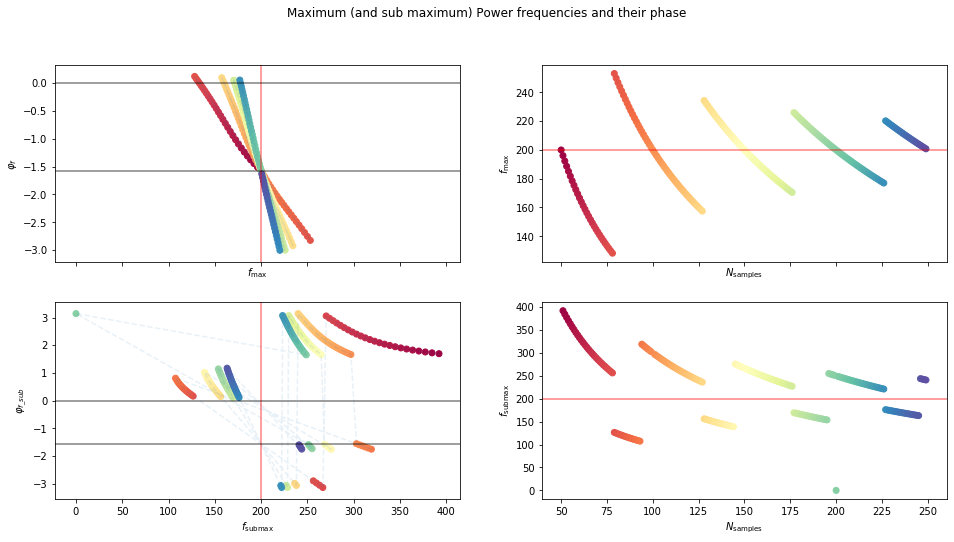

In [5]:
# \phi_f vs f_max for differing \Delta f
N_delta_f = 200

plot_submax = True


Ns_samples = required_N_samples//1 + np.arange(0, N_delta_f)
phi_f = np.empty(N_delta_f)
f_max = np.empty(N_delta_f)

if plot_submax:
    phi_f_sub = np.empty(N_delta_f)
    f_submax  = np.empty(N_delta_f)

for i, N_sample in enumerate(Ns_samples):
    time = np.arange(N_sample) / sample_rate
    
    fft, freqs = ft_spectrum(signal_func(2*np.pi*f*time), sample_rate)
    
    fft_power = np.abs(fft)**2
    id_max = np.argmax(fft_power)
    
    phi_f[i] = np.angle(fft[id_max])
    f_max[i] = freqs[id_max]
    
    if plot_submax:
        fft_power[id_max] = 0
        id_submax = np.argmax( fft_power )
        
        phi_f_sub[i] = np.angle(fft[id_submax])
        f_submax[i]  = freqs[id_submax]

if plot_submax:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16,8), sharex="col")
    fig.suptitle("Maximum (and sub maximum) Power frequencies and their phase")
else:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
    fig.suptitle("Maximum Power frequencies and their phase")
        
    
# Maximum values
ax1.set_xlabel('$f_\\mathrm{max}$')
ax1.set_ylabel('$\\varphi_f$')
ax1.plot(f_max, phi_f, '--', alpha=0.1)
sc = ax1.scatter(f_max, phi_f, c=Ns_samples, cmap='Spectral')
ax1.axvline(f, color='r', alpha=0.5, label="Signal frequency")
for hline in [0, -np.pi/2]:
    ax1.axhline(hline, color='k', alpha=0.5)

ax2.set_xlabel('$N_\\mathrm{samples}$')
ax2.set_ylabel('$f_\\mathrm{max}$')
ax2.scatter(Ns_samples, f_max, c=Ns_samples, cmap='Spectral')
ax2.axhline(f, color='r', alpha=0.5, label="Signal frequency")

# SubMaximum values
if plot_submax:
    
    # filter submax frequencies above twice the frequency
    if True:
        idx_submax = np.argwhere(np.abs(f_submax) < 2*f)
        
        f_submax = f_submax[idx_submax]
        phi_f_sub = phi_f_sub[idx_submax]
        
        Ns_samples_submax = Ns_samples[idx_submax]
    else:
        Ns_samples_submax = Ns_samples
        
    
    ax3.set_xlabel('$f_\\mathrm{submax}$')
    ax3.set_ylabel('$\\varphi_{f\_sub}$')
    ax3.plot(f_submax, phi_f_sub, '--', alpha=0.1)
    sc = ax3.scatter(f_submax, phi_f_sub, c=Ns_samples_submax, cmap='Spectral')
    ax3.axvline(f, color='r', alpha=0.5, label="Signal frequency")
    for hline in [0, -np.pi/2]:
        ax3.axhline(hline, color='k', alpha=0.5)

    ax4.set_xlabel('$N_\\mathrm{samples}$')
    ax4.set_ylabel('$f_\\mathrm{submax}$')
    ax4.scatter(Ns_samples_submax, f_submax, c=Ns_samples_submax, cmap='Spectral')
    ax4.axhline(f, color='r', alpha=0.5, label="Signal frequency")



if False:
    res = 50
    ax1.set_xlim(f-res, f+res)
    ax2.set_ylim(f-res, f+res)
    if plot_submax:
        ax4.set_ylim(f-res, f+res)
plt.show()

## $\varphi_f$ vs $\varphi_t$ and the effect of $f/f_\mathrm{sample}$

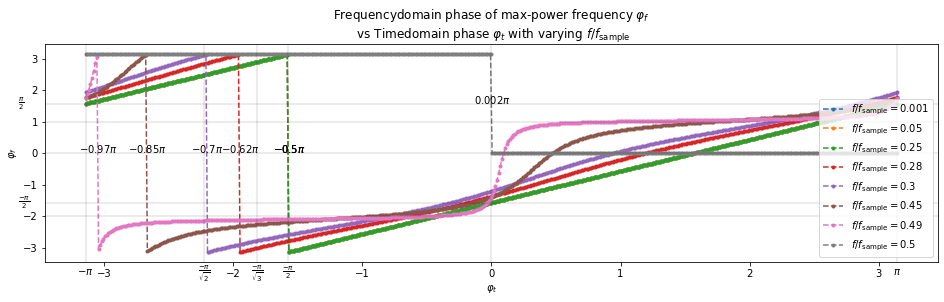

In [6]:
sample_rate = 1/1e-4 # Hz

phase_offsets = np.linspace(-np.pi, np.pi, 500, endpoint=True)# rad

frequencies = sample_rate * np.array([0.5, 0.49, 0.45, 0.3, 0.28, 0.25, 0.05, 0.001])

signal_func = lambda phase: np.sin(phase)


# Precreate figure and axis
fig, (ax1) = plt.subplots(1,1, figsize=(16,4))

for f in frequencies[::-1]:
    
    required_N_samples = sample_rate/f

    phi_f = np.empty_like(phase_offsets)

    time = np.arange(required_N_samples) / sample_rate

    for i, offset in enumerate(phase_offsets):

        fft, freqs = ft_spectrum(signal_func(2*np.pi*f*time + offset), sample_rate)       
        id_max = np.argmax(np.abs(fft)**2)

        phi_f[i] = np.angle(fft[id_max])
    
    
    ax1.plot(phase_offsets, phi_f, '.--', label="$f/f_\\mathrm{{sample}} = {}$".format(f/sample_rate))

    if True:
        id_phi_f_min = np.argmin(phi_f)
        ylocation = (np.max(phi_f) + np.min(phi_f)) /2
        ax1.text(phase_offsets[id_phi_f_min], ylocation, "${:.2g}\\pi$".format(phase_offsets[id_phi_f_min]/np.pi), horizontalalignment='center')

        
ax1.set_title("Frequencydomain phase of max-power frequency $\\varphi_f$ \n vs Timedomain phase $\\varphi_t$ with varying $f / f_\\mathrm{{sample}}$")
ax1.set_xlabel('$\\varphi_t$')
ax1.set_ylabel('$\\varphi_f$')
ax1.legend(loc='lower right')

# grid lines
## vertical lines
vlines = [
    (-np.pi, r'$-\pi$'),
    (-np.pi/np.sqrt(2), r'$\frac{-\pi}{\sqrt{2}}$'),
    (-np.pi/np.sqrt(3), r'$\frac{-\pi}{\sqrt{3}}$'),
    (-np.pi/2, r'$\frac{-\pi}{2}$'),
    (np.pi, r'$\pi$'),
]

xtrans = ax1.get_xaxis_transform()
ax1.axhline(0, alpha=0.1, color='k')
for location, label in vlines:
    ax1.axvline(location, alpha=0.1, color='k')
    ax1.text(location, -0.06, label, transform=xtrans, horizontalalignment='center')

## horizontal lines
hlines = [
    (1, ''),
    (-2, ''),
    (-np.pi/2, r'$\frac{-\pi}{2}$'),
    (np.pi/2, r'$\frac{\pi}{2}$'),
]

ytrans = ax1.get_yaxis_transform()
ax1.axvline(0, alpha=0.1, color='k')
for location, label in hlines:
    ax1.axhline(location, alpha=0.1, color='k')
    ax1.text(-0.03, location, label, transform=ytrans, verticalalignment='center')
    
plt.show()

For $f_\mathrm{sample} \geq 3f$ the relationship between $\varphi_t$ and $\varphi_f$ is (almost) linear.

From $f_\mathrm{sample} \geq 4f$ onwards, this relationship is stable with

$$
\varphi_f = \varphi_t - \frac{\pi}{2} \delta_\mathrm{sin}
,
$$
where $\delta_\mathrm{sin}$ is 1 if the signal was a sine, and 0 for a cosine.

# reconstruct phase from off-frequency ft

Require atleast $f_\mathrm{sample} \geq 4 f$

In [7]:
sample_rate = 1/1e-4 # Hz
f = 100 # Hz
required_N_samples = sample_rate/f

phase_to_retrieve = phase_modulo(-np.pi/2)
signal_func = lambda phase: np.cos(phase + phase_to_retrieve)

print("Required signal length is: {}s".format(1/f))
print("Required number of samples: {}".format(required_N_samples))
print("Phase to be retrieved: {}".format(phase_to_retrieve))

Required signal length is: 0.01s
Required number of samples: 100.0
Phase to be retrieved: -1.5707963267948966


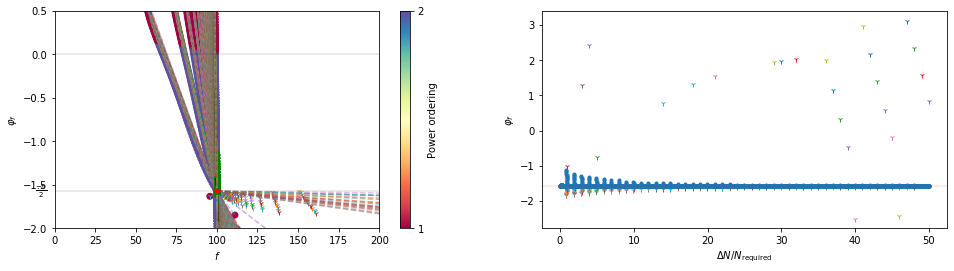

In [8]:
N_deltas = 0*required_N_samples + np.arange(1, 50*required_N_samples+1, 1) # set !={0, required_N_sample} for imperfect FT


# flags
unfold_phases = True
N_sub_max = 2 # how many peaks to get
enable_single_max = True
diffs_on_single_max = True
keep_single_max_phase = True



retrieved_phases = np.empty_like(N_deltas)
submax_amplitudes = np.empty((len(N_deltas), N_sub_max))

fig, axes = plt.subplots(1,2, figsize=(16,4))

for i, N_delta in enumerate(N_deltas):
    # require N_sub => 2
    N_sub_max = max(2, N_sub_max)
    idx_max = np.empty(N_sub_max, dtype=np.int)
    fft_power_max = np.zeros(N_sub_max)

    time = np.arange(required_N_samples+N_delta) / sample_rate
    
    f_delta = sample_rate/(required_N_samples+N_delta)

    fft, ft_freqs = ft_spectrum(signal_func(2*np.pi*f*time), sample_rate)
    fft_power = np.abs(fft)**2
    

    idx_single_max = None
    for sub in range(len(idx_max)):
        idx = np.argmax(fft_power)
        idx_max[sub] = idx
        fft_power_max[sub] = fft_power[idx]
        fft_power[idx] = 0 # mask current fft power
        
        if f_delta < np.abs(ft_freqs[idx] - f):
            idx_single_max = idx
            continue

    submax_amplitudes[i] = fft_power_max

    # No use to interpolate when the max-amplitude frequency
    # is within the frequency resolution of f
    if enable_single_max and idx_single_max is not None:
        freqs = ft_freqs[idx_single_max]
        angles = np.angle(fft[idx_single_max])
        
        if keep_single_max_phase:
            retrieved_phases[i] = angles
        
        l = axes[0].plot(freqs, angles, '1', label=r'$\Delta N = {}$'.format(N_delta))
        
        axes[1].plot(N_delta/required_N_samples, angles, '1', color=l[0].get_color())

        if not diffs_on_single_max:
            continue
    
    freqs = ft_freqs[idx_max]
    angles = np.angle(fft[idx_max])

    # fold angles down for higher submax frequencies
    if unfold_phases:
        folds = 0
        for j in range(len(freqs) - 1):
            if freqs[j] < freqs[j+1] and angles[j] < angles[j+1]:
                folds += 1
                angles[j+1] += - 2*np.pi*folds

                if False:
                    print(freqs[j], freqs[j+1], "\t|", folds, "\t|", angles[j], angles[j+1])



    # plot frequencies and angles
    axes[0].plot(freqs, angles, '--', alpha=0.5, label=r'$\Delta N = {}$'.format(N_delta))
    sc = axes[0].scatter(freqs, angles, c=np.arange(len(freqs),0, -1), cmap='Spectral')
    
    # find interpolation between peaks to get the original phase
    dphi_df = (angles[0]-angles[1])/(freqs[0]-freqs[1])
    offset = angles[1] - dphi_df * freqs[1]
    
    angle_at_f = dphi_df * f + offset

    # modulo phase
    if not unfold_phases:
        angle_at_f = phase_modulo(angle_at_f)
      
    retrieved_phases[i] = angle_at_f
    axes[0].plot(f, angle_at_f, 'g^')
    
    # Try to fix the midpoints of each line
    if False:
        freq_midpoint = (freqs[0]-freqs[1])/2 + freqs[1]
        angle_midpoint = (angles[0]-angles[1])/2 + angles[1]
        interp_angle_midpoint = dphi_df*freq_midpoint + offset
        
        # modulo phase
        if not unfold_phases:
            angle_midpoint = phase_modulo(angle_midpoint)
            interp_angle_midpoint = phase_modulo(interp_angle_midpoint)
    
        l = axes[0].plot(freq_midpoint, angle_midpoint, '+')
        axes[0].plot(freq_midpoint, interp_angle_midpoint, 'x', color=l[0].get_color())
    
    
# plot retrieved phases
axes[1].plot(N_deltas/required_N_samples, phase_modulo(retrieved_phases), '.--')

cbar = fig.colorbar(sc, ax=axes[0])
cbar.ax.set_ylabel("Power ordering")
cbar.set_ticks([sc.colorbar.vmin, sc.colorbar.vmax])


## horizontal lines
hlines = [
    (0, None),
    (-np.pi/2, r'$\frac{-\pi}{2}$'),
]

ytrans = axes[0].get_yaxis_transform()
for location, label in hlines:
    axes[0].axhline(location, alpha=0.1, color='k')
    axes[0].text(-0.06, location, label, transform=ytrans, verticalalignment='center')
    
axes[0].plot(f, phase_to_retrieve, 'r*')
axes[0].set_xlabel("$f$")
axes[0].set_ylabel(r"$\varphi_f$")
axes[0].axvline(f, alpha=0.1)



axes[1].set_xlabel(r"$\Delta N / N_\mathrm{required}$")
axes[1].set_ylabel(r"$\varphi_f$")
axes[1].axhline(phase_to_retrieve, alpha=0.1, color='r')

# zooming
if True:
    x_res = 100
    y_min = -2
    y_max = 0.5
    
    if False:
        x_res = 0.3
        y_min = phase_to_retrieve - 0.1
        y_max = phase_to_retrieve + 0.1

    axes[0].set_xlim(f-x_res, f+x_res)
    axes[0].set_ylim(y_min, y_max)
    

plt.show()

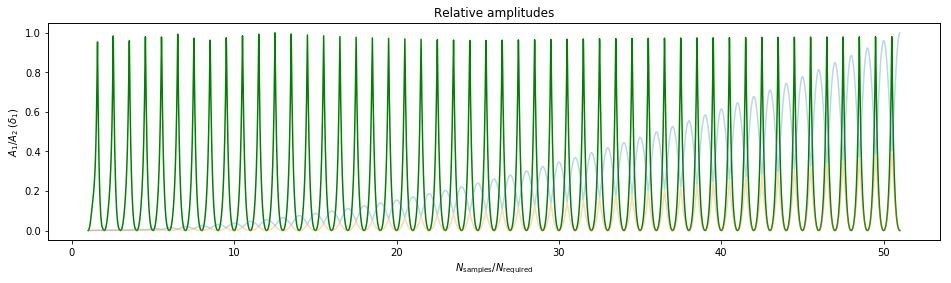

In [9]:
# Relative Amplitudes of the maximum and submaximum amplitudes plot
fig2, axs2 = plt.subplots(1,1,figsize=(16,4))

relative_amplitudes = np.empty_like(submax_amplitudes)
for i, amps in enumerate(submax_amplitudes):
    relative_amplitudes[i] = amps[1:] / amps[0]
    

axs2.plot(1+N_deltas/required_N_samples, relative_amplitudes[:,1], 'g')

axs2_submax = axs2.twinx()
axs2_submax.plot(1+N_deltas/required_N_samples, submax_amplitudes[:,0], alpha=0.3)
axs2_submax.plot(1+N_deltas/required_N_samples, submax_amplitudes[:,1], alpha=0.3)
axs2_submax.set_yticks([],[])

axs2.set_title("Relative amplitudes")
axs2.set_xlabel(r"$N_\mathrm{samples} / N_\mathrm{required}$")
axs2.set_ylabel(r"$A_1/A_2 \; (\delta_1)$")



plt.show()